## Simple NHL RAPM
##### Helpful Sources:

https://nbviewer.jupyter.org/gist/EvanZ/48bf713ce9eb14f28d58

https://hockey-graphs.com/2019/01/14/reviving-regularized-adjusted-plus-minus-for-hockey/

In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from pandasql import sqldf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from datetime import datetime
print(datetime.now())

2020-09-26 00:28:55.722456


In [2]:
#Loading and inspecting the PBP dataset
shifts = pd.read_csv('csv_shiftdata.csv', encoding = "ISO-8859-1")
shifts.head()

C:\Users\devli\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (29,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,season,game_id,game_date,session,event_index,game_period,game_seconds,event_type,event_description,...,home_goalie,away_goalie,home_team,away_team,home_skaters,away_skaters,home_score,away_score,game_score_state,game_strength_state
0,1,20172018,2017020001,2017-10-04,R,1,1,0,PGSTR,,...,NaN,NaN,WPG,TOR,0,0,0,0,0v0,EvE
1,2,20172018,2017020001,2017-10-04,R,2,1,0,PGEND,,...,NaN,NaN,WPG,TOR,0,0,0,0,0v0,EvE
2,3,20172018,2017020001,2017-10-04,R,3,1,0,ANTHEM,,...,NaN,NaN,WPG,TOR,0,0,0,0,0v0,EvE
3,4,20172018,2017020001,2017-10-04,R,4,1,0,PSTR,Period Start- Local time: 6:17 CDT,...,NaN,NaN,WPG,TOR,0,0,0,0,0v0,EvE
4,5,20172018,2017020001,2017-10-04,R,5,1,0,CHANGE,NaN,...,NaN,FREDERIK.ANDERSEN,WPG,TOR,0,5,0,0,0v0,Ev5


In [3]:
#Selecting shot change data from the 19-20 season - not very pythonic
df = shifts
df = sqldf("SELECT * FROM df WHERE event_type != 'GIVE' AND event_type != 'HIT' AND season = '20192020'")
df = df.reset_index()

In [4]:
#This creates additional columns that account for shots against/for, shift duration, score state, zone start, and
#whether or not the personnel on ice changed after a given event. This data forms the basis of our linear regression.
for_list = [0]
against_list = [0]
time_list = [0]
score_list = [0]
fo_list = ['none']
rapm_list = [0]
for i in range(1,len(df)):
    t1 = df.loc[i,'game_seconds']
    t0 = df.loc[i,'game_seconds']
    is_shift = 0
    for_count = 0
    against_count = 0
    shift_flag = True
    team_flag = True
    fo_flag = "none"
    if df.loc[i,'event_type'] == 'CHANGE' or df.loc[i,'event_team'] != df.loc[i - 1,'event_team']:
        is_shift = 1
        j = i + 1
        team0 = df.loc[j,'event_team']
        t0 = df.loc[i,'game_seconds']
        while j < len(df) - 1 and shift_flag and team_flag:
            if df.loc[j,'event_type'] == 'SHOT' or df.loc[j,'event_type'] == 'GOAL' or df.loc[j,'event_type'] == 'MISS' or df.loc[j,'event_type'] == 'BLOCK':
                if df.loc[j,'event_team'] == df.loc[j,'home_team']:
                    for_count += 1
                else:
                    against_count += 1
            if df.loc[j,'event_type'] == 'FAC':
                if df.loc[j,'event_team'] == df.loc[j,'home_team']:
                    if df.loc[j,'event_zone'] == 'Def':
                        fo_flag = 'hd'
                    elif df.loc[j,'event_zone'] == 'Off':
                        fo_flag = 'ho'
                elif df.loc[j,'event_team'] == df.loc[j,'away_team']:
                    if df.loc[j,'event_zone'] == 'Def':
                        fo_flag = 'ad'
                    elif df.loc[j,'event_zone'] == 'Off':
                        fo_flag = 'ao'
            if df.loc[j,'event_type'] == 'CHANGE':
                shift_flag = False
                t1 = df.loc[j,'game_seconds']
            j += 1
            team_flag = df.loc[j,'event_team'] == team0
    for_list.append(for_count)
    against_list.append(against_count)
    time_list.append(t1-t0)
    fo_list.append(fo_flag)
    rapm_list.append(is_shift)
    if df.loc[i,'home_score'] - df.loc[i,'away_score'] >= 3:
        score_list.append(3)
    elif df.loc[i,'home_score'] - df.loc[i,'away_score'] <= -3:
        score_list.append(-3)
    else:
        score_list.append(df.loc[i,'home_score'] - df.loc[i,'away_score'])

In [5]:
#Adding the above variables to the dataframe
df['duration'] = time_list
df['CF'] = for_list
df['CA'] = against_list
df['score_state'] = score_list
df['faceoff'] = fo_list
df['rapm'] = rapm_list

In [6]:
#Adjusting the Corsi For/Against from per second to per hour
df['CF/60'] = 60**2 * df['CF']/df['duration']
df['CA/60'] = 60**2 * df['CA']/df['duration']

In [7]:
#Selecting only stints, not every event
#Not a very efficient or pythonic way but mostly just using this package for SQL muscle memory
df_shifts = sqldf("SELECT * FROM df WHERE rapm = 1 AND game_strength_state = '5v5'")

In [8]:
#Dropping divide by zero errors
df_shifts.dropna(subset = ['CF/60','CA/60'], inplace=True)
df_shifts = df_shifts.reset_index()

In [9]:
#Creating categorical variables from tied to up/down 3
for i in range(1,4):
    df_shifts['score_is_' + str(i)] = 0

In [10]:
#Filling according to how much the home team is winning by
for i in range(len(df_shifts)):
    if df.loc[i,'score_state'] > 0:
        df_shifts.loc[i,'score_is_' + str(df.loc[i,'score_state'])] = 1
    elif df.loc[i,'score_state'] < 0:
        df_shifts.loc[i,'score_is_' + str(-1 * df.loc[i,'score_state'])] = -1

In [11]:
#Categorical variable for home ice advantage
df_shifts['is_home'] = 0
for i in range(len(df_shifts)):
    if df_shifts.loc[i,'event_team'] == df.loc[i,'home_team']:
        df_shifts.loc[i,'is_home'] = 1

In [12]:
#Categorical variable for offensive/defensive zone starts
df_shifts['zone'] = 0
for i in range(len(df_shifts)):
    if df_shifts.loc[i,'faceoff'] != 'none':
        if df_shifts.loc[i,'faceoff'] == 'ho' or df_shifts.loc[i,'faceoff'] == 'ad':
            df_shifts.loc[i,'oz_start'] = 1
        elif df_shifts.loc[i,'faceoff'] == 'ao' or df_shifts.loc[i,'faceoff'] == 'hd':
            df_shifts.loc[i,'dz_start'] = 1

In [13]:
#Creating a single target variable
df_shifts['C/60'] = df_shifts['CF/60'] - df_shifts['CA/60']

In [14]:
#Creating categorical variables for players on ice
#Essentially a huge matrix of 1, 0, -1 based on whether player is on offense or defense
units = []
for i in range(len(df_shifts)):
    home = []
    away = []
    for j in range(1,8):
        if df_shifts.loc[i,'home_on_' + str(j)] != df_shifts.loc[i,'home_goalie']:
            home.append(df_shifts.loc[i,'home_on_' + str(j)])
        if df_shifts.loc[i,'away_on_' + str(j)] != df_shifts.loc[i,'away_goalie']:
            away.append(df_shifts.loc[i,'away_on_' + str(j)])
    home_unit = {name:1 for name in home if name is not None}
    away_unit = {name:-1 for name in away if name is not None}
    stint = home_unit.copy()
    stint.update(away_unit)
    units.append(stint)

In [15]:
#Appending categorical variables to data
df_vars = df_shifts[['score_is_1', 'score_is_2', 'score_is_3', 'is_home', 'zone']].copy()

In [16]:
#Creating inputs for Ridge Regression, target is C/60, weights are shift duration, inputs are players on ice and categorical variables above
u = DictVectorizer(sparse=False)
u_mat = u.fit_transform(units)
points = df_shifts['C/60'].to_numpy()
weights = df_shifts['duration'].to_numpy()
X = np.concatenate((u_mat, df_vars.to_numpy()), 1)

In [17]:
#A Ridge Regression - designed to reduce effects of the extreme collinearity
clf = linear_model.RidgeCV(alphas=(np.array([100,1000,10000,25000])),cv=3)
clf.fit(X,points,sample_weight=weights)

RidgeCV(alphas=array([  100,  1000, 10000, 25000]), cv=3, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [22]:
#Alpha result - should have taken ~20 minutes to run the script to this point
print(clf.alpha_)
print(datetime.now())

25000
2020-09-26 00:54:20.999240


In [23]:
#Creating a list of player ratings - taken from NBA RAPM doc above
players = u.get_feature_names()
ratings = []
for player in players:
    ratings.append((player,clf.coef_[players.index(player)]))
ratings.sort(key=lambda tup: tup[1],reverse=True) # sort by rating in descending order

In [24]:
#Converting list to df
res_name = []
res_rapm = []
for idx, rating in enumerate(ratings):
    #print(idx+1, "{}".format(rating[0]), "{0:.2f}".format(rating[1]))
    res_name.append("{}".format(rating[0]))
    res_rapm.append(float("{0:.2f}".format(rating[1])))
    
res_dict = {'Player': res_name, 'C_pm_60': res_rapm}  
    
res_df = pd.DataFrame(res_dict)
#res_df

In [25]:
#Importing Evolving Hockey RAPM results
eh = pd.read_csv('EH_rapm_sk_stats_ev_regular_2020-09-16.csv')
me = res_df

me

,Player,C_pm_60
0,BRETT.KULAK,8.11
1,KEVIN.LABANC,6.96
2,VALERI.NICHUSHKIN,6.46
3,TYLER.TOFFOLI,6.26
4,THOMAS.CHABOT,6.24
5,TOMAS.TATAR,6.17
6,BRADY.TKACHUK,6.15
7,ADRIAN.KEMPE,5.79
8,CLAUDE.GIROUX,5.73
9,JAKE.GUENTZEL,5.56


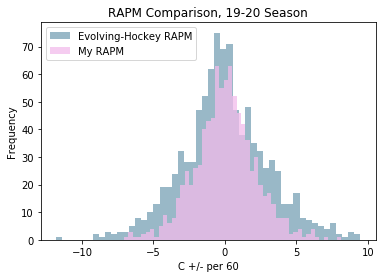

In [26]:
#Plotting histogram to compare distributions
eh['C_pm_60'].plot(kind='hist', bins = 50, color='#77a1b5', alpha = 0.75, label = 'Evolving-Hockey RAPM')
me['C_pm_60'].plot(kind='hist', bins = 50, color='#f2bbeb', alpha = 0.75,  label = 'My RAPM')
plt.xlabel('C +/- per 60')
plt.title('RAPM Comparison, 19-20 Season')
plt.legend()
plt.show()

In [27]:
#Fixing name convention
names = []
for name in me['Player']:
    n = (name.replace('.',' '))
    names.append(n.title())

me['Player'] = names

In [28]:
#Joining DF
df_fin = sqldf("SELECT a.Player, a.C_pm_60 as 'My RAPM', b.C_pm_60 as 'EH RAPM' FROM me as a JOIN eh as b ON a.Player = b.Player")

y=0.848164x+(0.016268)


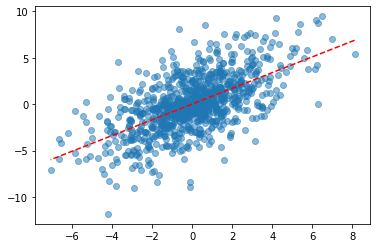

In [29]:
#Scatterplot of my RAPM vs the Evolving Hockey RAPM
x = df_fin['My RAPM']
y = df_fin['EH RAPM']

plt.scatter(x = x, y = y, alpha = 0.5)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
# the line equation:
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

In [30]:
#R^2
r2_score(df_fin['EH RAPM'], df_fin['My RAPM'])

0.35927970902481066

In [31]:
#Comparison in C/60 effect
df_fin['Delta'] = df_fin['My RAPM'] - df_fin['EH RAPM']

In [32]:
df_fin = df_fin.sort_values('EH RAPM', ascending=False)
df_fin['EH Rank'] = range(1,len(df_fin) + 1)

In [33]:
#Z-Scores for the figures to regularize data
cols = ['My RAPM', 'EH RAPM']
for c in cols:
    df_fin['z_' + c] = (df_fin[c] - df_fin[c].mean())/df_fin[c].std(ddof=0)

In [36]:

df_fin.sort_values('EH RAPM', ascending=False)

,Player,My RAPM,EH RAPM,Delta,EH Rank,z_My RAPM,z_EH RAPM
2,Valeri Nichushkin,6.46,9.47,-0.149512,1,2.991899,3.141411
26,Sean Couturier,4.21,9.29,-1.128864,2,1.952834,3.081698
6,Tomas Tatar,6.17,9.04,-0.140789,3,2.857975,2.998764
4,Tyler Toffoli,6.26,8.76,-0.006340,4,2.899538,2.905878
11,Lars Eller,5.36,8.65,-0.385475,5,2.483912,2.869387
332,Oliver Bjorkstrand,0.63,8.50,-2.520060,6,0.299567,2.819626
592,Craig Smith,-0.65,8.15,-2.995064,7,-0.291546,2.703518
12,Shea Theodore,5.26,7.77,-0.139727,8,2.437731,2.577458
28,Adam Fox,4.12,7.64,-0.623061,9,1.911271,2.534332
81,Dougie Hamilton,2.89,7.63,-1.187765,10,1.343249,2.531015


In [40]:
df_fin = df_fin.sort_values('Player', ascending=True)
df_fin.reset_index(inplace=True)
df_fin['Delta'] = abs(df_fin['index'] - df_fin['EH Rank'])
df_fin.sort_values('Delta', ascending=False)

,level_0,index,Player,My RAPM,EH RAPM,Delta,EH Rank,z_My RAPM,z_EH RAPM
55,55,882,Andrew Mangiapane,-3.68,4.51,816,66,-1.690820,1.495995
18,18,64,Alex Biega,3.16,-3.95,783,847,1.467937,-1.310501
483,483,829,Kailer Yamamoto,-2.72,3.61,731,98,-1.247486,1.197431
534,534,183,Luke Glendening,1.57,-5.99,721,904,0.733665,-1.987245
733,733,99,Radim Simek,2.63,-2.83,680,779,1.223180,-0.938956
113,113,798,Brandon Saad,-2.29,3.35,677,121,-1.048909,1.111180
278,278,161,Drew Doughty,1.87,-3.54,665,826,0.872207,-1.174489
303,303,211,Esa Lindell,1.43,-4.64,663,874,0.669012,-1.539400
891,891,721,Vinnie Hinostroza,-1.50,4.74,662,59,-0.684082,1.572294
111,111,158,Brandon Montour,1.91,-3.32,656,814,0.890679,-1.101507
